# Generate AIBL cohort dataset and residuals files in hdf5 format

In [1]:
# Import data from Excel sheet
import pandas as pd
df = pd.read_excel('aibl_ptdemog_final.xlsx', sheet_name='aibl_ptdemog_final')
#print(df)
sid = df['RID']
grp = df['DXCURREN']
age = df['age']
sex = df['PTGENDER(1=Female)']
tiv = df['Total'] # TIV
field = df['field_strength']
grpbin = (grp > 1) # 1=CN, ...

In [2]:
# Scan for nifti file names
import glob
dataAIBL = sorted(glob.glob('mwp1_MNI_AIBL/*.nii.gz'))
dataFiles = dataAIBL
numfiles = len(dataFiles)
print('Found ', str(numfiles), ' nifti files')

Found  606  nifti files


In [3]:
# Match covariate information
import re
debug = False
cov_idx = [-1] * numfiles # list; array: np.full((numfiles, 1), -1, dtype=int)
print('Matching covariates for loaded files ...')
for i,id in enumerate(sid):
  p = [j for j,x in enumerate(dataFiles) if re.search('_%d_MR_' % id, x)] # extract ID numbers from filename, translate to Excel row index
  if len(p)==0:
    if debug: print('Did not find %04d' % id) # did not find Excel sheet subject ID in loaded file selection
  else:
    if debug: print('Found %04d in %s: %s' % (id, p[0], dataFiles[p[0]]))
    cov_idx[p[0]] = i # store Excel index i for data file index p[0]
print('Checking for scans not found in Excel sheet: ', sum(x<0 for x in cov_idx))

labels = pd.DataFrame({'Group':grpbin}).iloc[cov_idx, :]
grps = pd.DataFrame({'Group':grp, 'RID':sid}).iloc[cov_idx, :]

Matching covariates for loaded files ...
Checking for scans not found in Excel sheet:  0


In [4]:
# Actually load nifti files into array
import nibabel as nib
import numpy as np
from sklearn import linear_model
# define FOV to reduce required memory size
x_range_from = 10; x_range_to = 110
y_range_from = 13; y_range_to = 133
z_range_from = 5; z_range_to = 105
# 1. dimension: subject
# 2. dimension: img row
# 3. dimension: img col
# 4. dimension: img depth
# 5. dimension: img channel
images = np.zeros((numfiles, z_range_to-z_range_from, x_range_to-x_range_from, y_range_to-y_range_from, 1), dtype=np.float32) # numfiles× z × x × y ×1; avoid 64bit types
#print(images.shape)

for i in range(numfiles):   # for loop over files and load
  if (i % 50 == 0):
    print('Loading file %d of %d' % (i+1, numfiles))
  img = nib.load(dataFiles[i])
  img = img.get_fdata()[x_range_from:x_range_to, y_range_from:y_range_to, z_range_from:z_range_to]
  img = np.transpose(img, (2, 0, 1)) # reorder dimensions to match coronal view z*x*y in MRIcron etc.
  #img = np.fliplr(img) # flip upside down and
  #img = np.flipud(img) # left/right to match MRIcroN views when plotted directly
  #img = np.flip(img, 2) # flip front/back
  img = np.flip(img) # flip all positions
  #print(img.shape)
  images[i, :,:,:, 0] = np.nan_to_num(img)
print('Successfully loaded files')
print('Image array size: ', images.shape)

Loading file 1 of 606
Loading file 51 of 606
Loading file 101 of 606
Loading file 151 of 606
Loading file 201 of 606
Loading file 251 of 606
Loading file 301 of 606
Loading file 351 of 606
Loading file 401 of 606
Loading file 451 of 606
Loading file 501 of 606
Loading file 551 of 606
Loading file 601 of 606
Successfully loaded files
Image array size:  (606, 100, 100, 120, 1)


In [5]:
# save original images array to disk
import h5py
hf = h5py.File('orig_images_AIBL_wb_mwp1_CAT12_MNI.hdf5', 'w')
hf.create_dataset('images', data=images, compression='gzip')
hf.close()

displaying image  mwp1_MNI_AIBL\mwp1AIBL_1000_MR_MPRAGE_ADNI_confirmed__br_raw_20090107130529821_43_S61337_I132872.nii.gz


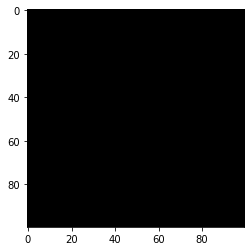

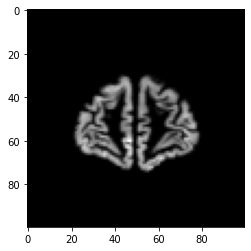

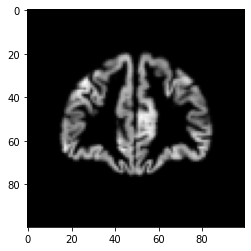

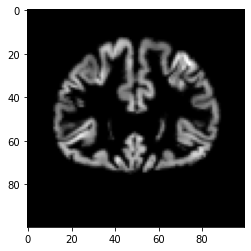

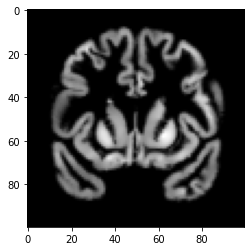

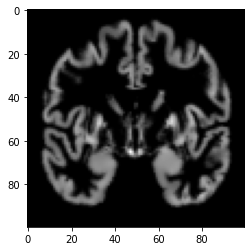

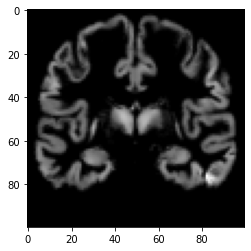

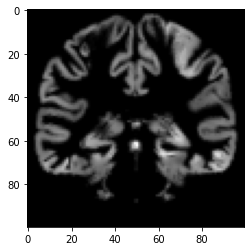

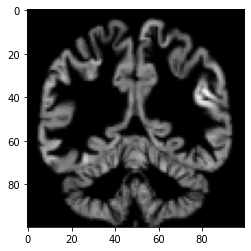

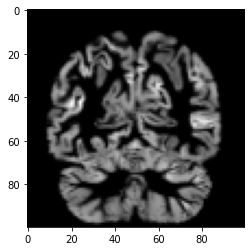

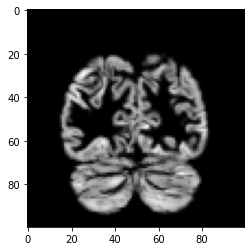

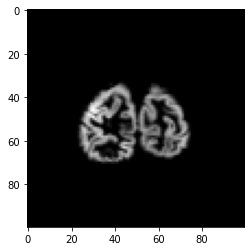

In [6]:
# Display a single scan
from matplotlib import pyplot as plt
%matplotlib inline
#import numpy as np
test_img = images[0, :,:,:, 0]
ma = np.max(test_img)
mi = np.min(test_img)
test_img = (test_img - mi) / (ma - mi) # normalising to (0-1) range
#test_img = (test_img - test_img.mean())/test_img.std() # normalizing by mean and sd
print('displaying image ', dataFiles[0])
for i in range(test_img.shape[2]):
  if (i % 10 == 0): # only display each tenth slice
    plt.figure()
    a = test_img[:,:,i]
    plt.imshow(a, cmap='gray')

In [6]:
# Perform regression-based covariates cleaning
from sklearn import linear_model
from pandas import DataFrame

covariates = DataFrame({'Age':age, 'Sex':sex, 'TIV':tiv, 'FieldStrength':field}).iloc[cov_idx, :]
print("Covariates data frame size : ", covariates.shape)
print(covariates.head())
#print(label.head())
covariates = covariates.to_numpy(dtype=np.float32) # convert dataframe to nparray with 32bit types

# not run: estimate model using AIBL controls -> instead apply ADNI2 model
##covCN = covariates[labels['Group'] == 0] # only controls as reference group to estimate effect of covariates
##print("Controls covariates data frame size : ", covCN.shape)
# load coefficients for linear models from hdf5
hf = h5py.File('linear_models_ADNI2.hdf5', 'r')
hf.keys  # read keys
lmarray = np.array(hf.get('linearmodels'), dtype=np.float32)  # stores 4 coefficients + 1 intercept per voxel
hf.close()
lm = linear_model.LinearRegression()

for k in range(images.shape[3]):
  print('Processing depth slice ', str(k+1), ' of ', str(images.shape[3]))
  for j in range(images.shape[2]):
    for i in range(images.shape[1]):
      if any(images[:, i, j, k, 0] != 0):
        # not run: estimate model using AIBL controls -> instead apply ADNI2 model
        ##tmpdat = images[labels['Group'] == 0, i, j, k, 0]
        ##lm.fit(covCN, tmpdat) # estimate model coefficients (intercept added automatically)
        # take model coefficients from ADNI2 file
        lm.coef_ = lmarray[k, j, i, :4]
        lm.intercept_ = lmarray[k, j, i, 4]
        pred = lm.predict(covariates) # calculate prediction for all subjects
        images[:, i, j, k, 0] = images[:, i, j, k, 0] - pred # % subtract effect of covariates from original values (=calculate residuals)

Covariates data frame size :  (606, 4)
     Age  Sex      TIV  FieldStrength
365   66  1.0  1341.84            3.0
366   74  0.0  1553.70            3.0
367   83  1.0  1372.72            3.0
60    77  0.0  1487.43            3.0
368   72  1.0  1355.21            3.0
Processing depth slice  1  of  120
Processing depth slice  2  of  120
Processing depth slice  3  of  120
Processing depth slice  4  of  120
Processing depth slice  5  of  120
Processing depth slice  6  of  120
Processing depth slice  7  of  120
Processing depth slice  8  of  120
Processing depth slice  9  of  120
Processing depth slice  10  of  120
Processing depth slice  11  of  120
Processing depth slice  12  of  120
Processing depth slice  13  of  120
Processing depth slice  14  of  120
Processing depth slice  15  of  120
Processing depth slice  16  of  120
Processing depth slice  17  of  120
Processing depth slice  18  of  120
Processing depth slice  19  of  120
Processing depth slice  20  of  120
Processing depth slice

In [7]:
# Save residualized data to disk
import h5py
hf = h5py.File('residuals_AIBL_wb_mwp1_CAT12_MNI.hdf5', 'w')
hf.create_dataset('images', data=images, compression='gzip')
# don't store Strings or String arrays in HDF5 containers as this is problematic
hf.close()

displaying residual image  mwp1_MNI_AIBL\mwp1AIBL_1000_MR_MPRAGE_ADNI_confirmed__br_raw_20090107130529821_43_S61337_I132872.nii.gz


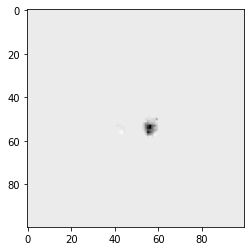

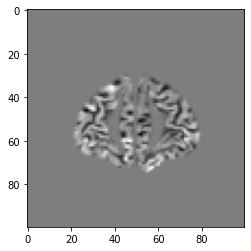

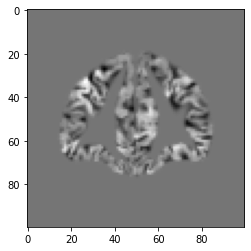

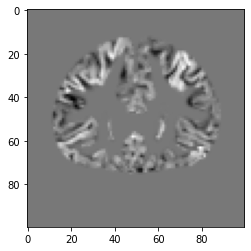

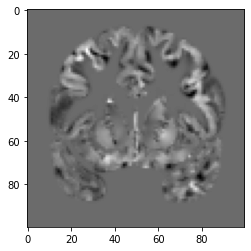

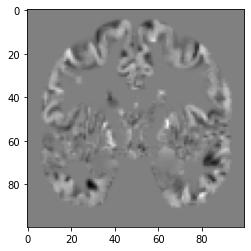

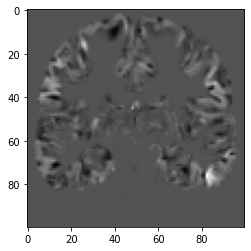

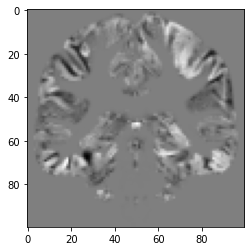

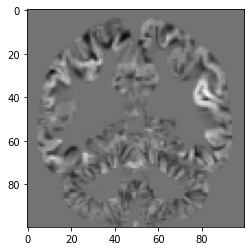

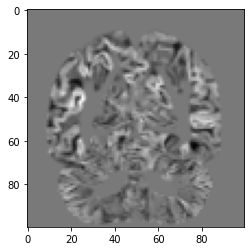

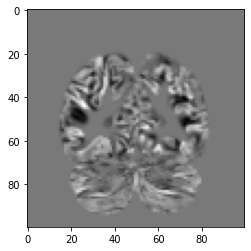

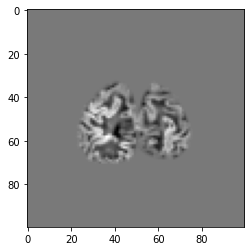

In [9]:
# Display a single scan (residuals)
from matplotlib import pyplot as plt
#import numpy as np
test_img = images[0, :,:,:, 0]
ma = np.max(test_img)
mi = np.min(test_img)
test_img = (test_img - mi) / (ma - mi) # normalising to (0-1) range
#test_img = (test_img - test_img.mean())/test_img.std() # normalizing by mean and sd
print('displaying residual image ', dataFiles[0])
for i in range(test_img.shape[2]):
  if (i % 10 == 0): # only display each fifth slice
    plt.figure()
    a = test_img[:,:,i]
    plt.imshow(a, cmap='gray')